In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import torch
import numpy as np
import torchvision
import torch.optim as optim
import torch.functional as F
import torch.utils.data as data
from torchvision import transforms

from utils import ColorizeDataSet, LabEncoder, CategoricalColorizeDataSet

from torchvision.datasets.folder import has_file_allowed_extension, default_loader, IMG_EXTENSIONS
import os
import PIL
import torch
import numpy as np
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab

In [2]:
ds_train = CategoricalColorizeDataSet('/tmp/data/train',  transform=transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224)
                           ]))
ds_train.limit = 8
train_loader = data.DataLoader(ds_train,batch_size=8, shuffle=False)
ds_test = CategoricalColorizeDataSet('/tmp/data/test',  transform=transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                           ]))
ds_test.limit = 16
test_loader = data.DataLoader(ds_test,batch_size=16, shuffle=False)

In [3]:
class ClassificationModel(nn.Module):
    
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.seq = nn.Sequential(
            
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2), nn.LeakyReLU(), nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2), nn.LeakyReLU(), nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=2), nn.LeakyReLU(), nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(512),

            # bottleneck, in future, fusion
            nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(256),

            # decoder
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(128),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(64),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(32),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(16),
            nn.Conv2d(16, 262, kernel_size=1, padding=0)
        )
    
    def forward(self, x):
        x = self.seq(x)
        # b, c, h, w => b, h, w, c
        #x = x.permute(0,2,3,1)
        return x
        

In [4]:
model = ClassificationModel()

In [5]:
model.cuda()
x,y = next(iter(train_loader))
x,y = x.cuda(),y.cuda()
yhat = model(x)

In [6]:
yhat.shape

torch.Size([8, 262, 224, 224])

In [197]:
values, indices = torch.max(yhat, 1)

In [198]:
nn_idx = indices[0,:,:].cpu().numpy()


In [9]:
#nn_idx = y.cpu().numpy()[0,:]

In [10]:
l_img = x.cpu().numpy()[0,0,:]
ab_img = ds_train.enc.decode_histo_to_ab(nn_idx)

In [11]:
lab_img = np.concatenate((l_img[:,:,None], ab_img), 2)

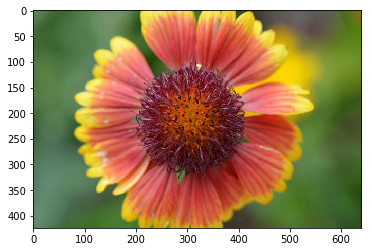

In [352]:
img = ds_train.get_pil(0)
rgb_img = np.asarray(img)
labimg = rgb2lab(rgb_img)
rgb_again = lab2rgb(labimg)
plt.imshow(rgb_again)

In [13]:
lab_img[:,:,1].max(), labimg[:,:,1].max(), lab_img[:,:,1].min(), labimg[:,:,1].min()

(92.0, 64.37598162998975, -88.0, -37.99027740856453)

In [14]:
lab_img[:,:,2].max(), labimg[:,:,2].max(), lab_img[:,:,2].min(), labimg[:,:,2].min()

(92.0, 87.75036098012558, -108.0, -42.22269316125554)

In [15]:
rgb_img = lab2rgb(lab_img)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1214 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


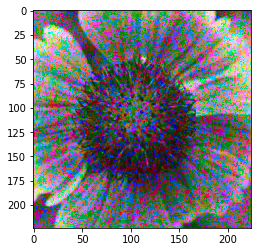

In [16]:
plt.imshow(rgb_img)

In [6]:
def train(model, optimizer, criterion, epochs=10, lrs=None):
    val_loss, val_acc = [], []
    for e in range(epochs):
        print(f"epoch: {e}")
        running_loss = 0.0
        running_num = 0 
        if lrs is not None: lrs.step()
        for inputs, labels in train_loader:
            model.train()
            inputs, labels = inputs.to('cuda'), labels.to('cuda') 

            optimizer.zero_grad()
            logits = model(inputs)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.shape[0]
            running_num += inputs.shape[0]
        
        print(f"running loss: {running_loss/running_num}")
        if e%10 == 0:
            vloss, vacc = get_validation_error(model)
            val_loss.append(vloss), val_acc.append(vacc)
    return pd.DataFrame({'loss': val_loss, 'acc': val_acc})

In [7]:
def get_validation_error(model):
    model.eval()
    loss = 0.0
    num = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        with torch.no_grad():
            a_out = model(inputs)
        _, yh = torch.max(a_out, 1)
        loss += criterion(a_out, labels).item() * labels.shape[0]
        num += labels.shape[0]
    print(f"Validation Loss: {loss/num}")
    return loss/num, 0.0

In [10]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#lrs = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
epochs = 600
stats_lr = train(model, optimizer, criterion, epochs, None)

epoch: 0
running loss: 5.632779598236084
Validation Loss: 5.579452037811279
epoch: 1
running loss: 5.591904163360596
epoch: 2
running loss: 5.641165733337402
epoch: 3
running loss: 5.512490272521973
epoch: 4
running loss: 5.462509632110596
epoch: 5
running loss: 5.389023303985596
epoch: 6
running loss: 5.342686176300049
epoch: 7
running loss: 5.2801194190979
epoch: 8
running loss: 5.223905563354492
epoch: 9
running loss: 5.160022258758545
epoch: 10
running loss: 5.097275257110596
Validation Loss: 185.3240966796875
epoch: 11
running loss: 5.027222156524658
epoch: 12
running loss: 4.95629358291626
epoch: 13
running loss: 4.880186080932617
epoch: 14
running loss: 4.804535388946533
epoch: 15
running loss: 4.724536895751953
epoch: 16
running loss: 4.6388702392578125
epoch: 17
running loss: 4.55242395401001
epoch: 18
running loss: 4.459191799163818
epoch: 19
running loss: 4.369018077850342
epoch: 20
running loss: 4.277234077453613
Validation Loss: 29.036441802978516
epoch: 21
running loss: 4

running loss: 1.3242676258087158
epoch: 177
running loss: 1.3144547939300537
epoch: 178
running loss: 1.3110096454620361
epoch: 179
running loss: 1.2988994121551514
epoch: 180
running loss: 1.298365592956543
Validation Loss: 10.679250717163086
epoch: 181
running loss: 1.2855079174041748
epoch: 182
running loss: 1.285232663154602
epoch: 183
running loss: 1.2730145454406738
epoch: 184
running loss: 1.2711687088012695
epoch: 185
running loss: 1.2628068923950195
epoch: 186
running loss: 1.2597461938858032
epoch: 187
running loss: 1.2553389072418213
epoch: 188
running loss: 1.2581535577774048
epoch: 189
running loss: 1.2787528038024902
epoch: 190
running loss: 1.3284457921981812
Validation Loss: 11.144217491149902
epoch: 191
running loss: 1.3403936624526978
epoch: 192
running loss: 1.3065546751022339
epoch: 193
running loss: 1.3243871927261353
epoch: 194
running loss: 1.291994571685791
epoch: 195
running loss: 1.2639515399932861
epoch: 196
running loss: 1.2782084941864014
epoch: 197
running

running loss: 1.0167036056518555
Validation Loss: 13.696782112121582
epoch: 351
running loss: 0.9960632920265198
epoch: 352
running loss: 1.0076838731765747
epoch: 353
running loss: 0.978579044342041
epoch: 354
running loss: 0.9931081533432007
epoch: 355
running loss: 0.970585286617279
epoch: 356
running loss: 0.9718246459960938
epoch: 357
running loss: 0.9667518138885498
epoch: 358
running loss: 0.9572564959526062
epoch: 359
running loss: 0.9560211300849915
epoch: 360
running loss: 0.9458569884300232
Validation Loss: 13.709005355834961
epoch: 361
running loss: 0.9507454633712769
epoch: 362
running loss: 0.9385136365890503
epoch: 363
running loss: 0.9391852617263794
epoch: 364
running loss: 0.933270275592804
epoch: 365
running loss: 0.928959310054779
epoch: 366
running loss: 0.9269685745239258
epoch: 367
running loss: 0.922175407409668
epoch: 368
running loss: 0.9211926460266113
epoch: 369
running loss: 0.9188675880432129
epoch: 370
running loss: 0.9171714782714844
Validation Loss: 13.

running loss: 0.7387630939483643
epoch: 524
running loss: 0.7424890398979187
epoch: 525
running loss: 0.7398961186408997
epoch: 526
running loss: 0.739704966545105
epoch: 527
running loss: 0.7510968446731567
epoch: 528
running loss: 0.7687446475028992
epoch: 529
running loss: 0.7903648018836975
epoch: 530
running loss: 0.8003543019294739
Validation Loss: 16.7015438079834
epoch: 531
running loss: 0.7730799913406372
epoch: 532
running loss: 0.7736513018608093
epoch: 533
running loss: 0.8094490170478821
epoch: 534
running loss: 0.7906272411346436
epoch: 535
running loss: 0.7746505737304688
epoch: 536
running loss: 0.7644968628883362
epoch: 537
running loss: 0.7499869465827942
epoch: 538
running loss: 0.7477089166641235
epoch: 539
running loss: 0.7345443964004517
epoch: 540
running loss: 0.7328625321388245
Validation Loss: 16.38623046875
epoch: 541
running loss: 0.729010820388794
epoch: 542
running loss: 0.7205016613006592
epoch: 543
running loss: 0.7177413105964661
epoch: 544
running loss

In [19]:
x,y = next(iter(train_loader))

In [20]:
with torch.no_grad():
    model.eval()
    xc, yc = x.cuda(), y.cuda()
    yhat = model(xc)
    print(criterion(yhat, yc))

tensor(4.6360, device='cuda:0')


In [32]:
rgb_img = ds_train.to_image(xc, yhat,8)
plt.imshow(rgb_img)

IndexError: index 8 is out of bounds for axis 0 with size 8

still very very sepia.... need to use mode IMO

## Look at training results

In [16]:
model = ClassificationModel()
checkpoint = torch.load('./best_so_far.pth')
model.load_state_dict(checkpoint['state_dict'])
x,y = next(iter(train_loader))
with torch.no_grad():
    model.eval()
    yhat = model(x)

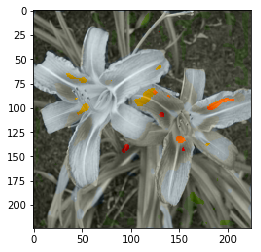

In [20]:
rgb_img = ds_train.to_image(x, yhat, 1)
plt.imshow(rgb_img)